In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import theano
import theano.tensor as T
import pymc3 as pm
import arviz as az
from scipy.stats.stats import pearsonr
from scipy import stats
! pip install statannot
from statannot import add_stat_annotation


In [2]:
test_df =pd.read_excel(r'data_all.xlsx')
test_df = test_df[test_df['key_resp.rt']<3];


In [3]:
test_df.drop(columns = ['trials.thisTrialN', 'trials.thisN', 'trials.thisIndex', 'psychopyVersion', 'frameRate', 'expName', 'date', 'session'], inplace = True)
test_df.rename(columns = {'trials.thisRepN':'rep_no', 'key_resp.keys':'patch_selected'}, inplace = True)
test_df['current_patch_comp'] = 0

In [4]:
for index, row in test_df.iterrows():
    # print(row['patch_selected'], (type(row['patch_selected'])))
    no_comp = 0
    if row['patch_selected'] == 'left':
        no_comp = row['left_competitors']
    else:
        no_comp = row['right_competitors']
    test_df.at[index, 'current_patch_comp'] = no_comp
test_df['threat'] = test_df['threat'].astype('bool')
test_df['str_threat']=test_df['threat'].astype(str)

test_df

,S.No,rep_no,left_competitors,right_competitors,threat,no_rewards,patch_selected,key_resp.rt,rewards_captured,shock,total_reward_captured,total_no_movements,participant,constant_reward,current_patch_comp,str_threat
0,1,0,5,1,True,1,left,0.669967,0,-100,-100,64,Harshit,0,5,True
1,2,1,5,1,False,1,right,0.399401,100,0,0,73,Harshit,0,1,False
2,3,2,2,5,False,4,left,0.437609,300,0,300,74,Harshit,0,2,False
3,4,3,5,1,False,2,right,0.378309,200,0,500,73,Harshit,0,1,False
4,5,4,1,4,True,2,left,0.460643,0,-100,400,29,Harshit,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,236,10,2,5,False,3,left,0.518962,200,0,1900,34,nitesh,1,2,False
236,237,11,1,4,True,3,left,0.682030,200,-100,2000,31,nitesh,1,1,True
237,238,12,2,5,True,3,right,0.236906,100,0,2100,37,nitesh,1,5,True
238,239,13,5,1,False,3,right,0.386927,300,0,2400,68,nitesh,1,1,False


In [5]:
constant_reward_df = test_df[test_df['constant_reward']==1]
variable_reward_df = test_df[test_df['constant_reward']==0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


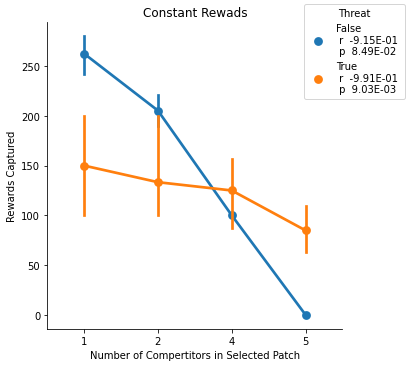

In [6]:
groupby_current_comp = constant_reward_df[constant_reward_df['threat']==1].groupby(['current_patch_comp']).mean()
r_threat,p_threat= pearsonr(groupby_current_comp.index.tolist(),groupby_current_comp['rewards_captured'].tolist())

groupby_current_comp = constant_reward_df[constant_reward_df['threat']==0].groupby(['current_patch_comp']).mean()
r_safe,p_safe= pearsonr(groupby_current_comp.index.tolist(),groupby_current_comp['rewards_captured'].tolist())

sctr = sns.catplot('current_patch_comp', 'rewards_captured', hue='threat', data=constant_reward_df, kind='point').set(title = "Constant Rewads" , ylabel = "Rewards Captured", xlabel = "Number of Compertitors in Selected Patch")
sctr._legend.texts[0].set_text(sctr._legend.texts[0].get_text() + "\n r  {:.2E} \n p  {:.2E}".format(r_threat,p_threat))
sctr._legend.texts[1].set_text(sctr._legend.texts[1].get_text() + "\n r  {:.2E} \n p  {:.2E}".format(r_safe,p_safe))
sns.move_legend(sctr, "upper right", title='Threat')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


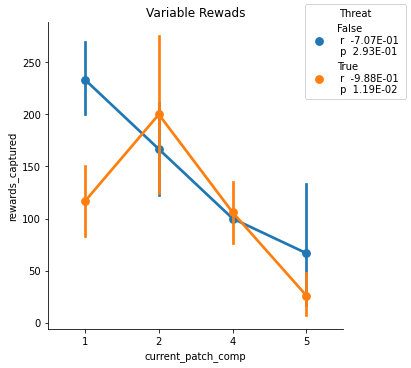

In [7]:
groupby_current_comp = variable_reward_df[variable_reward_df['threat']==1].groupby(['current_patch_comp']).mean()
r_threat,p_threat= pearsonr(groupby_current_comp.index.tolist(),groupby_current_comp['rewards_captured'].tolist())

groupby_current_comp = variable_reward_df[variable_reward_df['threat']==0].groupby(['current_patch_comp']).mean()
r_safe,p_safe= pearsonr(groupby_current_comp.index.tolist(),groupby_current_comp['rewards_captured'].tolist())

sctr = sns.catplot('current_patch_comp', 'rewards_captured', hue='threat', data=variable_reward_df , kind='point').set(title = "Variable Rewads")
sctr._legend.texts[0].set_text(sctr._legend.texts[0].get_text() + "\n r  {:.2E} \n p  {:.2E}".format(r_threat,p_threat))
sctr._legend.texts[1].set_text(sctr._legend.texts[1].get_text() + "\n r  {:.2E} \n p  {:.2E}".format(r_safe,p_safe))
sns.move_legend(sctr, "upper right", title='Threat')

In [8]:
test_df['total_reward_in_session'] = test_df['total_reward_captured']
for i, row in test_df.iterrows():
        ref  = ((i//5)*5)+4
        # print(ref)
        ref = test_df.loc[ref]['total_reward_captured']
        test_df.at[i, 'total_reward_in_session'] = ref


In [9]:
test_df['ppv'] = test_df['rewards_captured'] - 50/test_df['current_patch_comp']

ppv_mean = test_df['ppv'].mean()
test_df['ppv']= (test_df['ppv']-ppv_mean)/(test_df['ppv'].max()-test_df['ppv'].min())
test_df['ppv'] = test_df['ppv'] +abs( test_df['ppv'].min())
test_df['ppv']= (test_df['ppv'])/(test_df['ppv'].max()-test_df['ppv'].min())
test_df

,S.No,rep_no,left_competitors,right_competitors,threat,no_rewards,patch_selected,key_resp.rt,rewards_captured,shock,total_reward_captured,total_no_movements,participant,constant_reward,current_patch_comp,str_threat,total_reward_in_session,ppv
0,1,0,5,1,True,1,left,0.669967,0,-100,-100,64,Harshit,0,5,True,400,0.10000
1,2,1,5,1,False,1,right,0.399401,100,0,0,73,Harshit,0,1,False,400,0.25000
2,3,2,2,5,False,4,left,0.437609,300,0,300,74,Harshit,0,2,False,400,0.81250
3,4,3,5,1,False,2,right,0.378309,200,0,500,73,Harshit,0,1,False,400,0.50000
4,5,4,1,4,True,2,left,0.460643,0,-100,400,29,Harshit,0,1,True,400,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,236,10,2,5,False,3,left,0.518962,200,0,1900,34,nitesh,1,2,False,2400,0.56250
236,237,11,1,4,True,3,left,0.682030,200,-100,2000,31,nitesh,1,1,True,2400,0.50000
237,238,12,2,5,True,3,right,0.236906,100,0,2100,37,nitesh,1,5,True,2400,0.35000
238,239,13,5,1,False,3,right,0.386927,300,0,2400,68,nitesh,1,1,False,2400,0.75000


In [10]:
# sns.relplot('current_patch_comp', 'ppv', hue='no_rewards', data=variable_reward_df, kind="line", style="threat", ci=None)

In [11]:
constant_reward_df = test_df[test_df['constant_reward']==1]
variable_reward_df = test_df[test_df['constant_reward']==0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


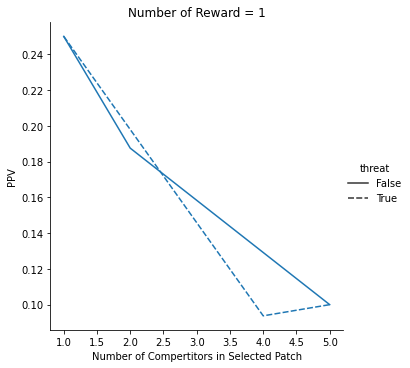

In [12]:
df_reward1 = variable_reward_df[variable_reward_df['no_rewards']==1]

sns.relplot('current_patch_comp', 'ppv', data=df_reward1, kind="line", style="threat", ci=None).set(title='Number of Reward = 1' , ylabel = "PPV", xlabel = "Number of Compertitors in Selected Patch")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


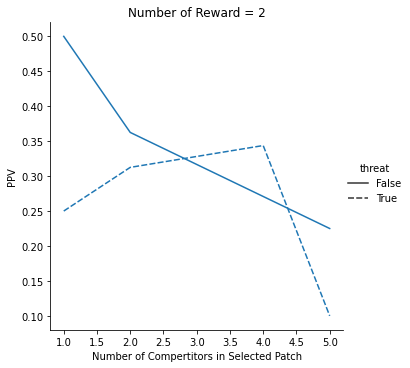

In [13]:
df_reward2 = variable_reward_df[variable_reward_df['no_rewards']==2]

sns.relplot('current_patch_comp', 'ppv', data=df_reward2, kind="line", style="threat", ci=None).set(title='Number of Reward = 2' , ylabel = "PPV", xlabel = "Number of Compertitors in Selected Patch")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


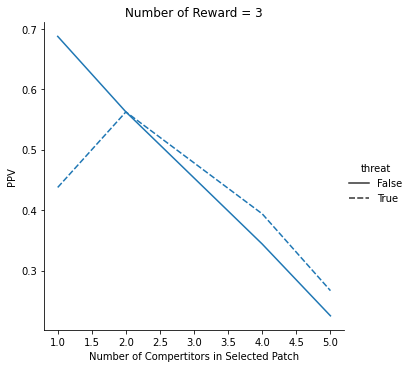

In [14]:
df_reward3 = variable_reward_df[variable_reward_df['no_rewards']==3]
groupby_current_comp = df_reward3[df_reward3['threat']==True].groupby(['current_patch_comp']).mean()
r_threat,p_threat= pearsonr(groupby_current_comp.index.tolist(),groupby_current_comp['ppv'].tolist())

groupby_current_comp = df_reward3[df_reward3['threat']==False].groupby(['current_patch_comp']).mean()
r_safe,p_safe= pearsonr(groupby_current_comp.index.tolist(),groupby_current_comp['ppv'].tolist())
sns.relplot('current_patch_comp', 'ppv', data=df_reward3, kind="line", style="threat", ci=None).set(title='Number of Reward = 3', ylabel = "PPV", xlabel = "Number of Compertitors in Selected Patch")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


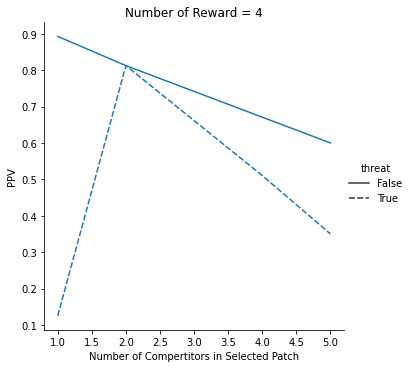

In [15]:
df_reward4 = variable_reward_df[variable_reward_df['no_rewards']==4]
sns.relplot('current_patch_comp', 'ppv', data=df_reward4, kind="line", style="threat", ci=None).set(title='Number of Reward = 4' , ylabel = "PPV", xlabel = "Number of Compertitors in Selected Patch")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


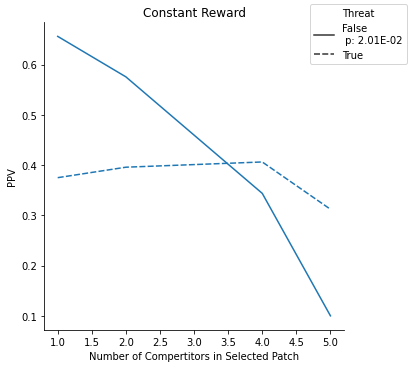

In [16]:
sc_plt = sns.relplot('current_patch_comp', 'ppv', data=constant_reward_df, kind="line", style="threat", ci=None).set(title='Constant Reward', ylabel = 'PPV', xlabel = 'Number of Compertitors in Selected Patch')
groupby_current_comp = constant_reward_df[constant_reward_df['threat']==False].groupby(['current_patch_comp']).mean()
r_safe,p_safe= pearsonr(groupby_current_comp.index.tolist(),groupby_current_comp['ppv'].tolist())
p_safe
sc_plt._legend.texts[0].set_text(sc_plt._legend.texts[0].get_text() + " \n p: {:.2E}".format(p_safe))
sns.move_legend(sc_plt, "upper right", title='Threat')

In [17]:
# df_reward5 = test_df[test_df['no_rewards']==5]
# sns.relplot('current_patch_comp', 'ppv', data=df_reward5, kind="line", style="threat", ci=None).set(title='Number of Reward = 5')

In [18]:
safe_df =  test_df[test_df['threat'] == 0]
threat_df = test_df[test_df['threat'] == 1]

In [19]:
threat_df_constant_reward = constant_reward_df[constant_reward_df['threat'] == 1]
safe_df_constant_reward = constant_reward_df[constant_reward_df['threat'] == 0]
threat_competetive_count =0 ; 
safe_competetive_count= 0 ;
threat_less_comp_count= 0 ; 
safe_less_comp_count= 0 ; 
for i, row in threat_df_constant_reward.iterrows(): 
  sel_patch = row['patch_selected'];
  left_comp = row['left_competitors'];
  right_comp = row['right_competitors'];
  if((sel_patch == 'left' and left_comp>right_comp )or (sel_patch == 'right' and left_comp<right_comp)):
    threat_competetive_count= threat_competetive_count + 1; 
  else : 
    threat_less_comp_count = threat_less_comp_count + 1; 
for i, row in safe_df_constant_reward.iterrows(): 
  sel_patch = row['patch_selected'];
  left_comp = row['left_competitors'];
  right_comp = row['right_competitors'];
  if((sel_patch == 'left' and left_comp>right_comp )or (sel_patch == 'right' and left_comp<right_comp)):
    safe_competetive_count= safe_competetive_count + 1; 
  else : 
    safe_less_comp_count = safe_less_comp_count + 1; 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Number of Choices'), Text(0.5, 1.0, 'Safe Case')]

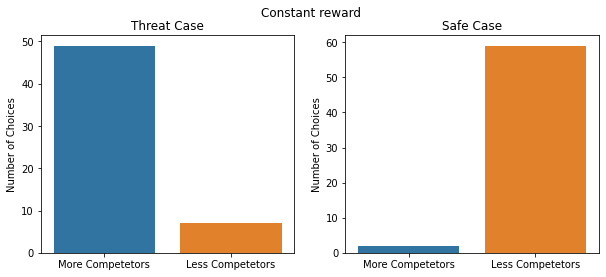

In [20]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
plt.suptitle("Constant reward")

sns.barplot( ['More Competetors','Less Competetors'], [threat_competetive_count, threat_less_comp_count],ax= axes[0]).set(
    title="Threat Case" , ylabel = "Number of Choices")

sns.barplot( ['More Competetors','Less Competetors'], [safe_competetive_count, safe_less_comp_count],ax= axes[1]).set(
    title="Safe Case" , ylabel = "Number of Choices")


In [21]:
threat_df_variable_reward = variable_reward_df[variable_reward_df['threat'] == 1]
safe_df_variable_reward = variable_reward_df[variable_reward_df['threat'] == 0]
threat_competetive_count =0 ; 
safe_competetive_count= 0 ;
threat_less_comp_count= 0 ; 
safe_less_comp_count= 0 ; 
for i, row in threat_df_variable_reward.iterrows(): 
  sel_patch = row['patch_selected'];
  left_comp = row['left_competitors'];
  right_comp = row['right_competitors'];
  if((sel_patch == 'left' and left_comp>right_comp )or (sel_patch == 'right' and left_comp<right_comp)):
    threat_competetive_count= threat_competetive_count + 1; 
  else : 
    threat_less_comp_count = threat_less_comp_count + 1; 
for i, row in safe_df_variable_reward.iterrows(): 
  sel_patch = row['patch_selected'];
  left_comp = row['left_competitors'];
  right_comp = row['right_competitors'];
  if((sel_patch == 'left' and left_comp>right_comp )or (sel_patch == 'right' and left_comp<right_comp)):
    safe_competetive_count= safe_competetive_count + 1; 
  else : 
    safe_less_comp_count = safe_less_comp_count + 1; 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Number of Choices'), Text(0.5, 1.0, 'Safe Case')]

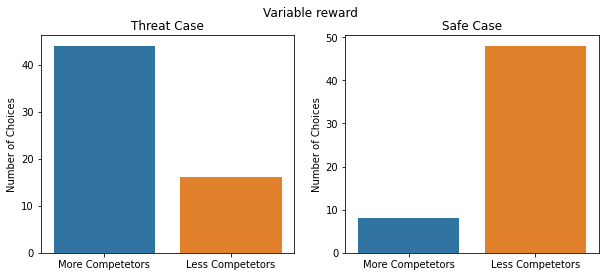

In [22]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
plt.suptitle("Variable reward")

sns.barplot( ['More Competetors','Less Competetors'], [threat_competetive_count, threat_less_comp_count],ax= axes[0]).set(
    title="Threat Case" , ylabel = "Number of Choices")
sns.barplot( ['More Competetors','Less Competetors'], [safe_competetive_count, safe_less_comp_count],ax= axes[1]).set(
    title="Safe Case" , ylabel = "Number of Choices")


In [23]:
# reaction time analysis 
mean_resp_time = test_df[test_df['key_resp.rt']<=3]['key_resp.rt'].mean()
constant_reward_df = constant_reward_df[constant_reward_df['key_resp.rt']<3];
variable_reward_df = variable_reward_df[variable_reward_df['key_resp.rt']<3];
threat_resp_time_constant_reward = threat_df_constant_reward[threat_df_constant_reward['key_resp.rt']<3]['key_resp.rt'].tolist(); 
threat_resp_time_variable_reward = threat_df_variable_reward[threat_df_variable_reward['key_resp.rt']<3]['key_resp.rt'].tolist();
safe_resp_time_constant_reward= safe_df_constant_reward[safe_df_constant_reward['key_resp.rt']<3]['key_resp.rt'].tolist();
safe_resp_time_variable_reward=safe_df_variable_reward[safe_df_variable_reward['key_resp.rt']<3]['key_resp.rt'].tolist();
safe_resp_time= safe_df[safe_df['key_resp.rt']<3]['key_resp.rt'].tolist();
threat_resp_time= threat_df[threat_df['key_resp.rt']<3]['key_resp.rt'].tolist();



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

True v.s. False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.444e-02 U_stat=2.061e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

True v.s. False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.241e-03 U_stat=2.265e+03


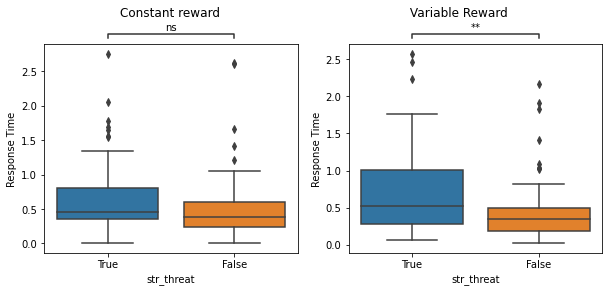

In [28]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
order = ['True', 'False']
bp1 = sns.boxplot(x='str_threat', y='key_resp.rt', data=constant_reward_df, ax= axes[0],order = order)
bp2 = sns.boxplot('str_threat', 'key_resp.rt', data=variable_reward_df, ax= axes[1],order=order)
bp1.set(ylabel = "Response Time")
bp2.set( ylabel = "Response Time")
add_stat_annotation(bp1, data=constant_reward_df, x='str_threat', y='key_resp.rt',order=order,
                    box_pairs=[("False", "True")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

add_stat_annotation(bp2, data=variable_reward_df, x='str_threat', y='key_resp.rt',order=order,
                    box_pairs=[("False", "True")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
plt.suptitle("Constant reward                                                 Variable Reward")
plt.subplots_adjust(top=0.85)

In [29]:
threat_df['more_comp_selected'] = True
for i, row in threat_df.iterrows():
    yes = True
    if row['patch_selected'] == 'left':
        if(row['left_competitors'] >= row['right_competitors']):
            yes = True
        else:
            yes = False
    else:
        if(row['right_competitors'] >= row['left_competitors']):
            yes = True
        else:
            yes = False
    threat_df.at[i, 'more_comp_selected'] = yes
threat_df['str_more_comp_selected']=threat_df['more_comp_selected'].astype(str)
threat_df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,S.No,rep_no,left_competitors,right_competitors,threat,no_rewards,patch_selected,key_resp.rt,rewards_captured,shock,total_reward_captured,total_no_movements,participant,constant_reward,current_patch_comp,str_threat,total_reward_in_session,ppv,more_comp_selected,str_more_comp_selected
0,1,0,5,1,True,1,left,0.669967,0,-100,-100,64,Harshit,0,5,True,400,0.10000,True,True
4,5,4,1,4,True,2,left,0.460643,0,-100,400,29,Harshit,0,1,True,400,0.00000,False,False
6,7,6,1,4,True,1,right,0.636372,0,0,700,80,Harshit,0,4,True,800,0.09375,True,True
7,8,7,1,4,True,3,left,0.398171,200,-100,800,49,Harshit,0,1,True,800,0.50000,False,False
8,9,8,5,1,True,2,right,1.150315,100,-100,800,27,Harshit,0,1,True,800,0.25000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,234,8,2,5,True,3,right,0.537860,200,0,1600,43,nitesh,1,5,True,1700,0.60000,True,True
234,235,9,5,1,True,3,right,0.237921,200,-100,1700,29,nitesh,1,1,True,1700,0.50000,False,False
236,237,11,1,4,True,3,left,0.682030,200,-100,2000,31,nitesh,1,1,True,2400,0.50000,False,False
237,238,12,2,5,True,3,right,0.236906,100,0,2100,37,nitesh,1,5,True,2400,0.35000,True,True


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Threat')

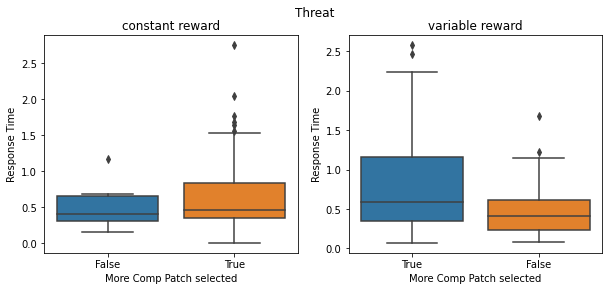

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)

order = ['False', 'True']
bp1 = sns.boxplot('str_more_comp_selected', 'key_resp.rt', data=threat_df[threat_df['constant_reward']==1], ax = axes[0])
bp2=  sns.boxplot('str_more_comp_selected', 'key_resp.rt', data=threat_df[threat_df['constant_reward']==0], ax = axes[1])

bp1.set(title = "constant reward",ylabel = "Response Time",xlabel="More Comp Patch selected")
bp2.set( title = "variable reward",ylabel = "Response Time",xlabel="More Comp Patch selected")

plt.suptitle("Threat")


In [31]:
safe_df['more_comp_selected'] = True
for i, row in safe_df.iterrows():
    yes = True
    if row['patch_selected'] == 'left':
        if(row['left_competitors'] >= row['right_competitors']):
            yes = True
        else:
            yes = False
    else:
        if(row['right_competitors'] >= row['left_competitors']):
            yes = True
        else:
            yes = False
    safe_df.at[i, 'more_comp_selected'] = yes
safe_df['str_more_comp_selected']=safe_df['more_comp_selected'].astype(str)

#safe_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0.98, 'Safe Patch')

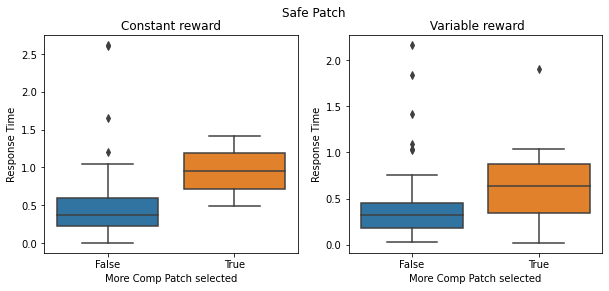

In [32]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
plt.suptitle("Safe case")
bp1 = sns.boxplot('str_more_comp_selected', 'key_resp.rt', data=safe_df[safe_df['constant_reward']==1], ax = axes[0], order = order)
bp2 =sns.boxplot('str_more_comp_selected', 'key_resp.rt', data=safe_df[safe_df['constant_reward']==0], ax = axes[1], order = order)
bp1.set(title = "Constant reward",ylabel = "Response Time",xlabel="More Comp Patch selected")
bp2.set(title = " Variable reward", ylabel = "Response Time",xlabel="More Comp Patch selected")

plt.suptitle("Safe Patch")


In [33]:
k=[];
for ind, row in constant_reward_df.iterrows():
   if row['patch_selected'] == 'left' : 
     k.append(row['left_competitors']);
   else : 
     k.append(row['right_competitors']);
constant_reward_df['Comp_in_selected_patch']=k 
k=[];
for ind, row in variable_reward_df.iterrows():
   if row['patch_selected'] == 'left' : 
     k.append(row['left_competitors']);
   else : 
     k.append(row['right_competitors']);
variable_reward_df['Comp_in_selected_patch']=k 

[Text(0, 0.5, 'Num of trial selected'), Text(0.5, 1.0, 'Variable_reward')]

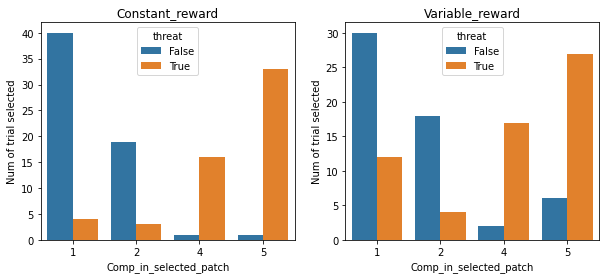

In [34]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1=sns.countplot(x='Comp_in_selected_patch',hue='threat',data=constant_reward_df, ax= axes[0])
ax1.set(ylabel='Num of trial selected', title = "Constant_reward")
ax2=sns.countplot(x='Comp_in_selected_patch',hue='threat',data=variable_reward_df, ax= axes[1])
ax2.set(ylabel='Num of trial selected', title ="Variable_reward")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.581e-14 U_stat=3.047e+03


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(<matplotlib.axes._subplots.AxesSubplot at 0x7f8ed8645b10>,
 [<statannot.StatResult.StatResult at 0x7f8ed85fa890>])

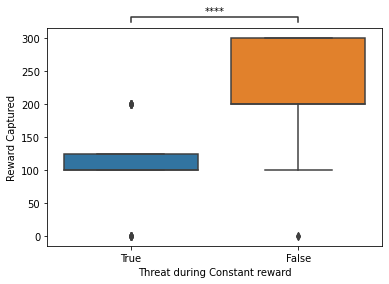

In [35]:
bp = sns.boxplot('str_threat', 'rewards_captured', data=constant_reward_df)
bp.set(ylabel = "Reward Captured",xlabel="Threat during Constant reward")
add_stat_annotation(bp, data=constant_reward_df, x='str_threat', y='rewards_captured',order=order,
box_pairs=[("False", "True")],
test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Threat Case')]

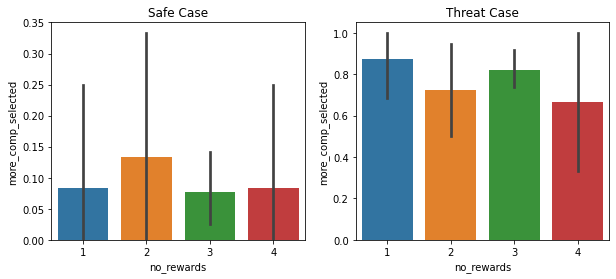

In [36]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)
sns.barplot('no_rewards', 'more_comp_selected', data=safe_df, ax = axes[0]).set(title="Safe Case")
sns.barplot('no_rewards', 'more_comp_selected', data=threat_df, ax = axes[1]).set(title="Threat Case")